<a href="https://colab.research.google.com/github/nafisenik/DataMinig_pySpark/blob/main/pySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import statistics
from time import time
import numpy as np
from operator import add
import matplotlib.pyplot as plt
import math
from pyspark.sql import SparkSession

In [2]:
def MC_pi_estimator(iteration):
  circle_point = 0
  total_point = 0
  p_list =[]
  hit = 0
  start = time()
  for i in range(iteration):
    x, y = random.uniform(-1, 1), random.uniform(-1, 1)   
    if x**2 + y**2 < 1:
      circle_point += 1
    total_point += 1
    pi_num = 4.0 * circle_point / total_point
    p_list.append(pi_num)
  t = np.round(time() - start, 3)
  return p_list, t, pi_num

In [3]:
ITERATION = 1000000
pi_list ,time, pi_est = MC_pi_estimator(ITERATION)
pi_mean = statistics.mean(pi_list)
pi_variance = statistics.variance(pi_list)
print(f'Mean of P estimate: {pi_mean}')
print(f'Variance of P estimate: {pi_variance}')

Mean of P estimate: 3.1452383664615278
variance of P estimate: 4.331806713411681e-05


### Q1

In [5]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 32 kB/s 
     |████████████████████████████████| 198 kB 48.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=990fd0a2484401278c54da4f8a04f031ddca58e9b0e872459c5a8a18b8929ad8
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [6]:
import pyspark as py
print(py.__version__)

3.2.1


In [ ]:
def is_inside(p):
  x, y = random.uniform(-1, 1), random.uniform(-1, 1)
  return x**2 + y**2 < 1 

### Q2


===== Naive Method =====
iterations: 10000		pi= 3.1364		seconds= 0.007
iterations: 50000		pi= 3.13608		seconds= 0.028
iterations: 100000		pi= 3.14496		seconds= 0.037
iterations: 500000		pi= 3.143336		seconds= 0.205
iterations: 1000000		pi= 3.145308		seconds= 0.373
iterations: 5000000		pi= 3.1417408		seconds= 1.864
iterations: 10000000		pi= 3.1402024		seconds= 3.776
iterations: 50000000		pi= 3.14168704		seconds= 18.8
iterations: 100000000		pi= 3.14146804		seconds= 37.645

===== Spark Method 4 clusters =====
iterations= 10000		pi= 3.1424		seconds= 2.45
iterations= 50000		pi= 3.11456		seconds= 0.291
iterations= 100000		pi= 3.1352		seconds= 0.306
iterations= 500000		pi= 3.1496		seconds= 0.632
iterations= 1000000		pi= 3.147088		seconds= 0.989
iterations= 5000000		pi= 3.1407008		seconds= 4.213
iterations= 10000000		pi= 3.1409072		seconds= 8.528
iterations= 50000000		pi= 3.14101152		seconds= 41.577
iterations= 100000000		pi= 3.14134304		seconds= 80.687

===== Spark Method 2 clusters =====
it

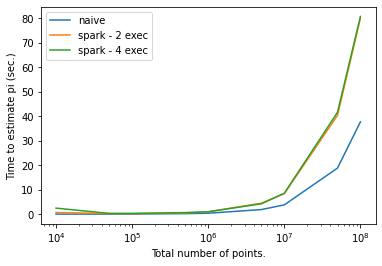

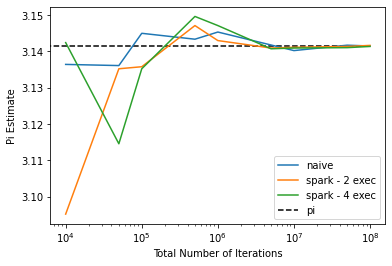

In [7]:
def MC_pi_spark(n, exec):

    start = time()
    hit = sc.parallelize(range(0, n), exec) \
        .map(is_inside).reduce(add)
    pi = 4.0 * hit / n
    timing = np.round(time() - start, 3)
    return pi, timing

spark = SparkSession.builder.appName('Pi').getOrCreate()
sc = spark.sparkContext

# Number of iterations
N = [10000, 50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000]

# Buffers to record the time taken for naive, default, and 2 clusters, respectively
T = []
T_spark_2_executors = []
T_spark_4_executors = []

# Buffers to record the value of pi for naive, 2 executers, and 4 executors
P = []
P_spark_2_executors = []
P_spark_4_executors = []

# Run naive and default Spark version
print("\n===== Naive Method =====")
for n in N:
    pi, t = naive_method(n)
    P.append(pi)
    T.append(t)               # Naive method

print("\n===== Spark Method 4 clusters =====")
for n in N:
    pi, t = spark_method(n, 4)
    P_spark_4_executors.append(pi)
    T_spark_4_executors.append(t)     # Default Spark method (4 clusters)

# Stop the Spark session
spark.stop()

# Since we cannot have 2 different sparks running at the same time, we close the previous
# one and start a new one and initialize how many clusters we want to use
# Run Spark version with 2 clusters
spark = SparkSession.builder.appName('EstimatePi').getOrCreate()
sc = spark.sparkContext
print("\n===== Spark Method 2 clusters =====")
for n in N:
    pi, t = spark_method(n, 2)
    P_spark_2_executors.append(pi)
    T_spark_2_executors.append(t)

spark.stop()

# Plot time taken for each iteration
plt.figure(1)
plt.plot(N, T, label="naive")
plt.plot(N, T_spark_2_executors, label="spark - 2 exec")
plt.plot(N, T_spark_4_executors, label="spark - 4 exec")

plt.xscale("log")
plt.xlabel("Total number of points.")
plt.ylabel("Time to estimate pi (sec.)")
plt.legend()
plt.show()

# Plot convergence of pi estimate
plt.figure(2)
plt.plot(N, P, label="naive")
plt.plot(N, P_spark_2_executors, label="spark - 2 exec")
plt.plot(N, P_spark_4_executors, label="spark - 4 exec")
plt.hlines(y=math.pi, xmin=0, xmax=100000000, colors='k', linestyles='dashed', label="pi")

plt.xscale("log")
plt.xlabel("Total Number of Iterations")
plt.ylabel("Pi Estimate")
plt.legend()
plt.show()